In [1]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import FastICA
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import normalize

import sys
import numpy as np
import matplotlib.pyplot as plt
from thunderfish.dataloader import load_data
from thunderfish.bestwindow import best_window
import pulse_tracker_helper as pth
import thunderfish.eventdetection as ed


In [2]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def MyDBSCAN(D, eps, MinPts,dt):
    """
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    MyDBSCAN takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    """
 
    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #     0 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = regionQuery(D, P, eps,dt)
        
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           growCluster(D, labels, P, NeighborPts, C, eps, MinPts,dt)
    
    # All data has been clustered!
    return labels


def growCluster(D, labels, P, NeighborPts, C, eps, MinPts,dt):
    """
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    """

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionQuery(D, Pn, eps, dt)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!


def regionQuery(D, P, eps, dt):
    """
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    """
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(P-dt, P+dt):
        
        if Pn > 0  and Pn < len(D):
            # If the distance is below the threshold, add it to the neighbors list.
            if np.linalg.norm(D[P] - D[Pn]) < eps:
                neighbors.append(Pn)
                
    return neighbors

In [3]:
def real_feat(y,dt,slope_num=4):

    w_num = slope_num - 2

    # for widths I would take the time instead of indices

    argmaxmin = extract_maxmin(y)
    maxmin = y[argmaxmin]
    slopes = np.diff(maxmin)
    widths = np.diff(argmaxmin)
    
    best_i = 0
    slope_sum = 0

    all_features = -np.ones((3,slope_num+w_num))

    if len(slopes)>=slope_num:

        all_features[:,:] = 0

        for i in range(len(argmaxmin)-slope_num):
            if np.sum(np.abs(slopes[i:i+slope_num])) > slope_sum:
                best_i = i
                slope_sum = np.sum(np.abs(slopes[i:i+slope_num]))

        for j,i in enumerate([-1,0,1]):
            s_idxs = np.arange(max(0,best_i+i),min(best_i+i+slope_num,len(slopes)))
            w_idxs = np.arange(max(1,best_i+i+1),min(best_i+i+slope_num-1,len(slopes)-1))

            if i == -1:
                all_features[j,slope_num-len(s_idxs):slope_num] = slopes[s_idxs]
                all_features[j,-len(w_idxs):] = widths[w_idxs]*dt            
            else:
                all_features[j,:len(s_idxs)] = slopes[s_idxs]
                all_features[j,-w_num:slope_num + len(w_idxs)] = widths[w_idxs]*dt

    return all_features

def extract_maxmin(y):

    ig = argrelextrema(y, np.greater)
    il = argrelextrema(y, np.less)
    
    argmaxmin = np.sort(np.append(ig,il)).astype('int')
    argmaxmin = np.append(np.append(0,argmaxmin),len(y)-1)

    return argmaxmin

def online_DBSCAN(data):
    return clusters

In [4]:
# load data:
# filename = sys.argv[1]

def extract_eod_times(data,thresh,peakwidth):
    
    print('extracting times')
    
    thresh = np.mean(np.abs(data))*2
    print(thresh)
    pk, tr = ed.detect_peaks(data, thresh)
    
    #plt.figure()
    #plt.plot(data)
    #plt.plot(pk,data[pk],'o')
    #plt.show()

    if len(pk)==0:
        return [], []
    else:
        peaks = pth.makeeventlist(pk,tr,data,peakwidth)
        print(peaks[:,0])
        peakindices, _, _ = pth.discardnearbyevents(peaks[0],peaks[1],peakwidth)
        return peaks[0][peakindices.astype('int')], peaks[1][peakindices.astype('int')]

def extract_pulsefish(data, samplerate, thresh=0.01):
    """
    This is what you should implement! Don't worry about wavefish for now.
    
    Parameters
    ----------
    data: 1-D array of float
        The data to be analysed.
    samplerate: float
        Sampling rate of the data in Hertz.
        
    Returns
    -------
    mean_eods: list of 2D arrays
        For each detected fish the average of the EOD snippets. First column is time in seconds,
        second column the mean eod, third column the standard error.
    eod_times: list of 1D arrays
        For each detected fish the times of EOD peaks in seconds.
    """
    
    ms, vs, ts = [], [], []
    
    
    # this would be the maximum pulsewidth.
    pw=0.002
    
    # 1. extract peaks
    idx_arr, h = extract_eod_times(data, thresh, pw*samplerate)
    
        
    if len(idx_arr) > 0:
        
        # this is the cutwidth..
        pw=0.001
    
        # 2. extract snippets
        idx_arr = idx_arr[(idx_arr>int(pw*samplerate/2)) & (idx_arr<(len(data)-int(pw*samplerate/2)))]

        #plt.figure()
        #plt.plot(data)
        #plt.plot(idx_arr,data[idx_arr.astype('int')],'o')

        #data = 2.*(data - np.min(data))/np.ptp(data)-1

        snippets = np.stack([data[int(idx-pw*samplerate/2):int(idx+pw*samplerate/2)] for idx in idx_arr])

        # remove cluster with the highest hight and then continue with leftover clusters.

        # 3. pre-process snippets
        # data = normalize(data.reshape(-1, 1))

        snippets = normalize(snippets)

        #plt.plot(snippets[0])
        #plt.show()
        #print(np.mean(snippets[0]))
        #print(np.mean(snippets[:,0]))

        # 4. extract relevant snippet features
        pca = PCA(10).fit(snippets).transform(snippets)

        # 5. cluster snippets based on waveform
        print(np.var(snippets))
        c = DBSCAN(eps=0.2,min_samples=10).fit(pca)

        # 5.b. cluster snippets based on size
        cz = DBSCAN(eps=0.2).fit(h.reshape(-1,1))

        #c = MyDBSCAN(normalize(pca),0.1,10,100)
        c=c.labels_
        # 6. for each cluster, extract the most meaningful time window
        # this is the window where var(mean)/mean(var) is max
        # r: also use this to discard bad clusters.
        # maybe use var(mean) for selecting window size.
        
        lw = 10

        for l in np.unique(c):
            if l != -1:  

                rs = []

                for rw in range(10,100):

                    # try different windows and different time shifts.
                    # use only indexes that fit with the cutwidth

                    c_i = idx_arr[c== l][(idx_arr[c== l]>lw) & (idx_arr[c== l]<(len(data)-rw))]

                    w = np.stack([data[int(idx-lw):int(idx+rw)] for idx in c_i])

                    m = np.mean(w,axis=0)
                    v = np.std(w,axis=0)
                    r = np.var(m)/np.mean(v)

                    rs.append(r)

                rw = (np.argmax(rs) + 10)

                rs = []

                for lw in range(10,100):
                    # try different windows and different time shifts.
                    c_i = idx_arr[c== l][(idx_arr[c== l]>lw) & (idx_arr[c== l]<(len(data)-rw))]
                    w = np.stack([data[int(idx-lw):int(idx+rw)] for idx in c_i])

                    m = np.mean(w,axis=0)
                    v = np.std(w,axis=0)
                    r = np.var(m)/np.mean(v)

                    rs.append(r)

                lw = (np.argmax(rs) + 10)


                print('rs')
                print(np.max(rs))
                if np.max(rs) > 0.005:
                    c_i = idx_arr[c== l][(idx_arr[c== l]>lw*4) & (idx_arr[c== l]<(len(data)-rw*3))]

                    w = np.stack([data[int(idx-lw*4):int(idx+rw*3)] for idx in c_i])
                    ms.append(np.mean(w,axis=0))
                    vs.append(np.std(w,axis=0))

                    ts.append(idx_arr[c==l])

                    #plt.figure()
                    #plt.plot(w.T)
                    #plt.show()

        # 7. possibly do the clustering again if the time window was too small/large?? 

        # after getting the window sizes, cluster again but then for the different window sizes?

        # or rerun if sized are too different?

        # 8. the mean that is returned will be normalized, maybe return the peak hights too?
    
    return ms, vs, ts

def plot_timepoints(data,eod_times):
    plt.figure()
    plt.plot(data)
    for t in eod_times:
        plt.plot(t,data[t.astype('int')],'o')
    plt.show()

def plot_eods(mean_eods,eod_std):
    for m,v in zip(mean_eods,eod_std):
        plt.figure()
        plt.plot(m,c='k')
        plt.fill_between(range(len(m)),m-v,m+v)
        plt.show()

In [5]:
from os import listdir
from os.path import isfile, join
mypath = 'test/'
filenames = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

0
1
2
test/095_Lake-Nabugabo-Uganda_2019-0x-0x_Stefan_Mucha_2_pulsefish.wav
0.0
extracting times
0.005413859405517578
[4.45000000e+02 3.26538086e-03 6.95800781e-03]
0.009999887517814127
0 fish
0


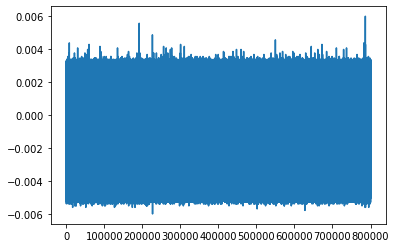

3
4
test/046_Leticia_2018-01-20_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.008334169864654541
[ 6.21000000e+02 -2.47192383e-03  1.58386230e-02]
0.018268775847129017
rs
0.04305060206172499
rs
0.008219319298098608
rs
0.0003500191226438296
2 fish
2


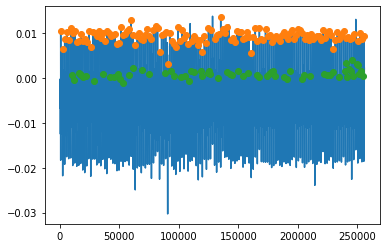

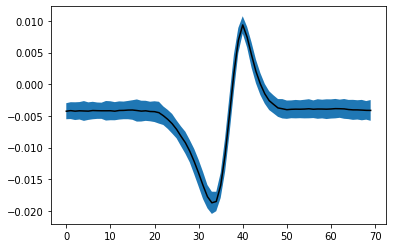

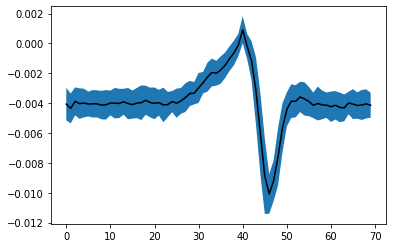

5
test/104_Panama_2014-05-17_Ruediger_Krahe_1_pulsefish.wav
0.0
extracting times
0.01492914581298828
[9.92000000e+02 3.18115234e-01 5.70953369e-01]
0.03123265176381179
rs
2.0348961887642654
rs
0.014561374665148206
2 fish
2


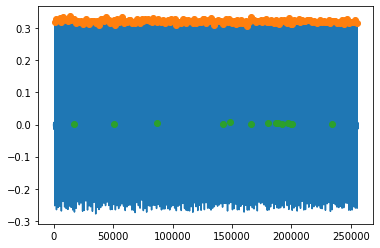

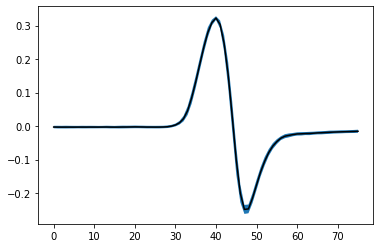

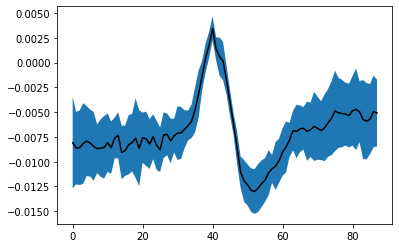

6
test/090_Leticia_2019-10-15_Jaqcui_Goebl_4_pulsefish.wav
0.0
extracting times
0.03207192611694336
[57.          0.35055542  0.5345459 ]
0.0312439908486845
rs
0.1769374413290722
rs
0.18198047558326544
2 fish
2


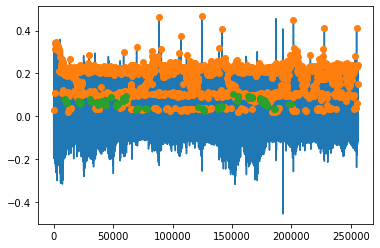

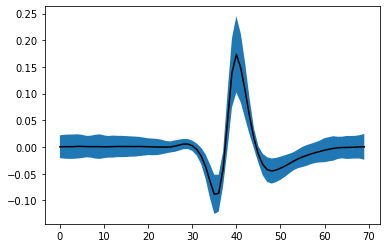

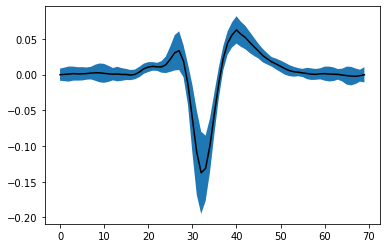

7
test/071_Leticia_2019-10-14_Jaqcui_Goebl_2_pulsefish.wav
0.0
extracting times
0.0031304020881652832
[7.10000000e+01 7.59887695e-03 2.46887207e-02]
0.026587181512419
rs
0.0784507104013632
rs
0.04669438782553814
2 fish
2


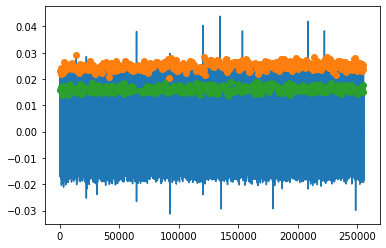

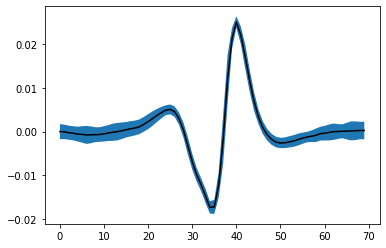

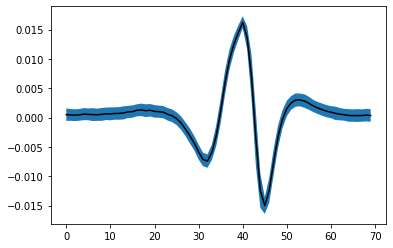

8
test/074_Leticia_2019-10-14_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.0029619686603546145
[4.00000000e+00 2.47192383e-03 4.69970703e-03]
0.025712351236249226
rs
0.16185367790413777
rs
0.00025129082707868135
1 fish
1


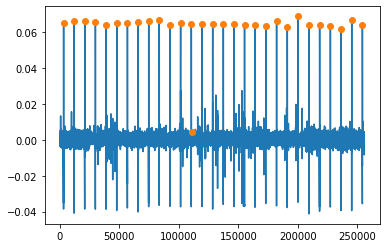

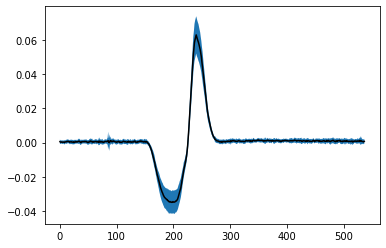

9
test/103_Panama_2014-05-17_Ruediger_Krahe_1_pulsefish.wav
0.0
extracting times
0.04244070816040039
[276.           0.90170288   1.67050171]
0.031248105864617678
rs
5.040143234946995
rs
0.07855035025753193
2 fish
2


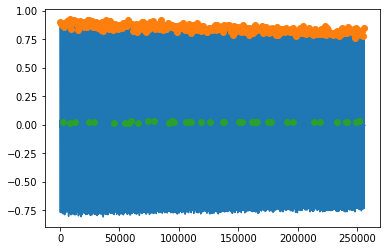

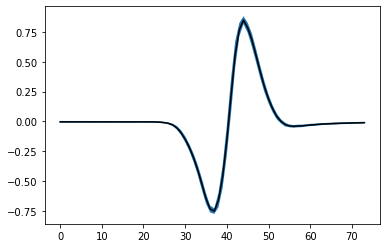

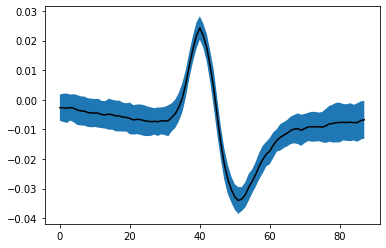

10
test/048_Leticia_2018-01-20_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.009087743520736694
[2.13000000e+02 1.22070312e-02 4.30908203e-02]
0.02661135103855098
rs
0.06253910922292659
rs
0.032766747337973794
rs
0.0025412489323272595
2 fish
2


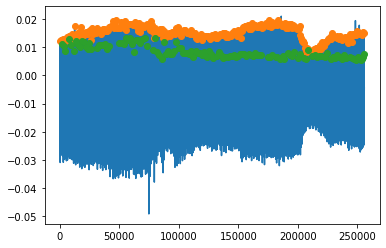

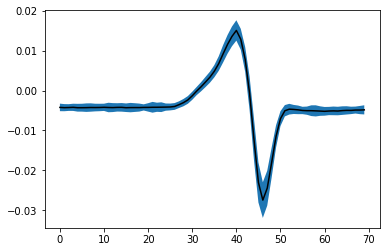

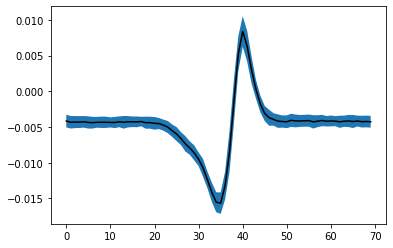

11
test/105_Panama_2014-05-17_Ruediger_Krahe_4_pulsefish.wav
0.0
extracting times
0.1183080894947052
[194.           0.99996948   1.85253906]
0.030958028140936962
rs
7.509125171085801
rs
0.1597888428244602
rs
0.32892128176543367
3 fish
3


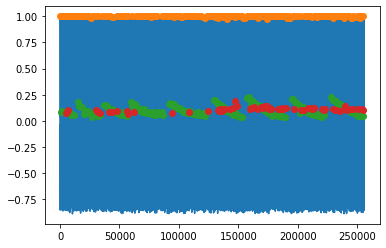

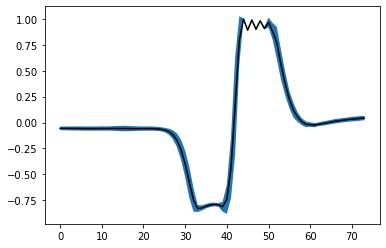

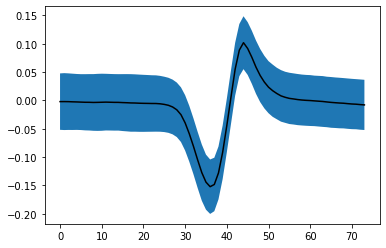

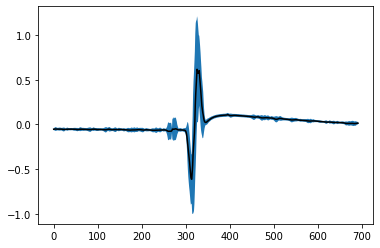

12
test/099_Panama_2014-05-17_Ruediger_Krahe_2_pulsefish.wav
0.0
extracting times
0.021245264768600464
[6.63000000e+02 1.16271973e-02 1.74865723e-01]
0.031147194656518815
rs
1.2482175433393627
rs
1.0255553023811628
2 fish
2


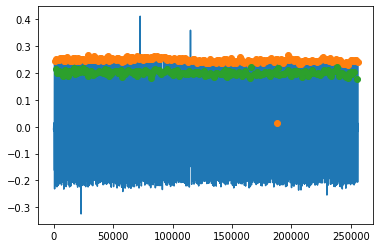

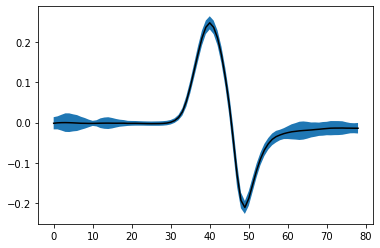

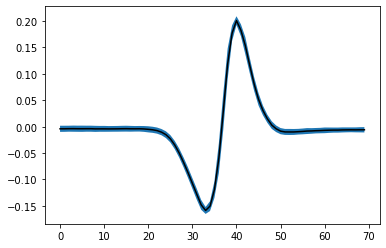

13
14
test/116_Sanmartin_2019-10-09_Jaqcui_Goebl_1_pulsefish.wav
0.0
extracting times
0.005107098579406738
[4.85000000e+02 2.97851562e-02 5.78002930e-02]
0.030993674456430673
rs
0.11999380038385671
rs
0.13713449718078177
2 fish
2


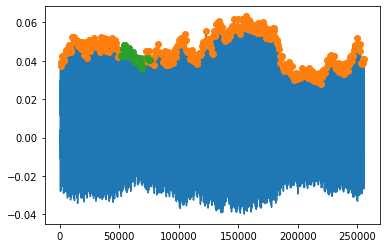

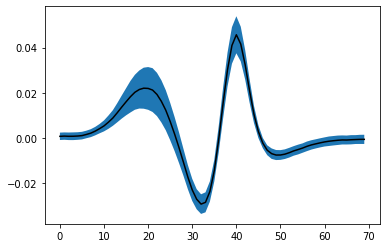

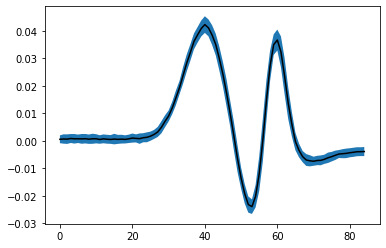

15
test/013_Leticia_2018-01-21_Jorge_Molina_1_pulsefish_eel.wav
0.0
extracting times
0.027428452491760253
[2.57500000e+03 8.08074951e-01 1.18814087e+00]
0.018258461564890183
rs
2.7777870091210968
1 fish
1


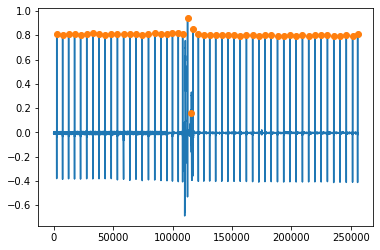

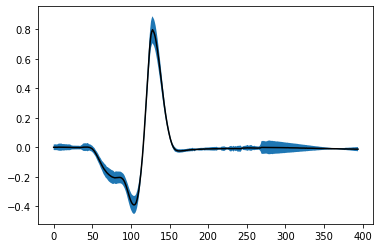

16
test/092_Lake-Nabugabo-Uganda_2019-0x-0x_Stefan_Mucha_3_pulsefish.wav
0.0
extracting times
0.0076810515594482424
[8.09000000e+02 4.30297852e-03 1.22680664e-02]
0.009975219473952506
rs
0.17705001231798073
rs
0.08215020260560066
2 fish
2


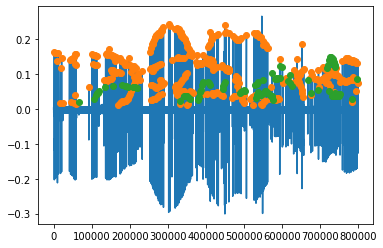

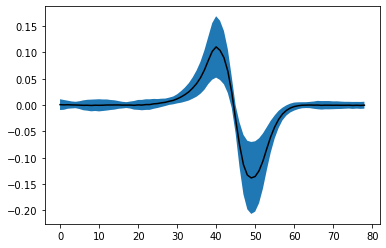

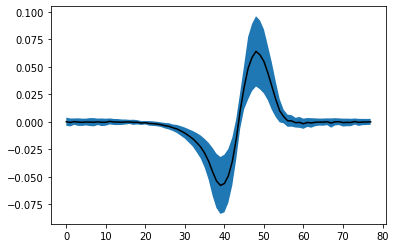

17
test/040_Leticia_2018-01-20_Jorge_Molina_2_pulsefish.wav
0.0
extracting times
0.010248804807662965
[7.50000000e+01 2.41088867e-03 1.32446289e-02]
0.019226631002611495
rs
0.0013035273133675514
rs
0.16569277441411404
rs
0.11811504633726623
2 fish
2


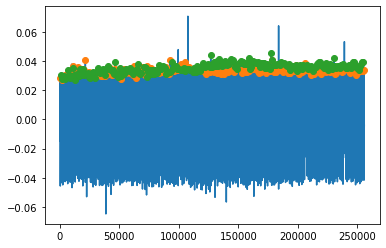

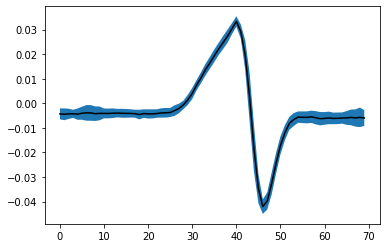

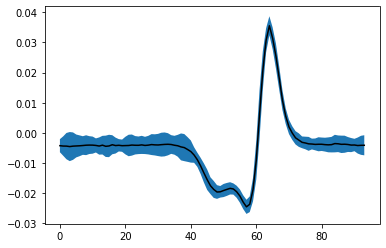

18
19
test/012_Leticia_2018-01-21_Jorge_Molina_2_pulsefish_eel.wav
0.0
extracting times
0.009773488283157349
[ 1.66000000e+02 -3.11279297e-03  1.20239258e-02]
0.015085382443244418
rs
0.001283532320043208
rs
0.016421762729228993
rs
0.11451102720225548
2 fish
2


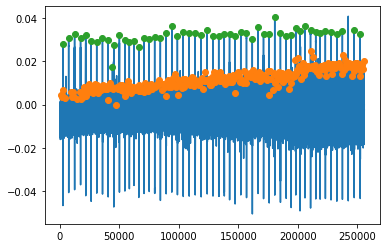

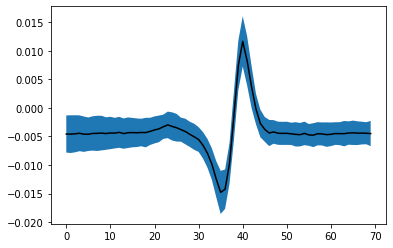

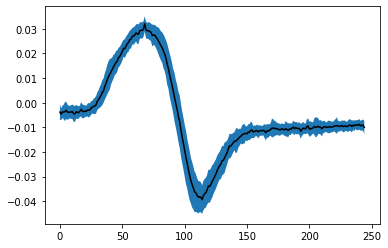

In [6]:
%matplotlib inline

# pulse extraction:
for i,filename in enumerate(filenames):
    print(i)
    if 'wavefish' not in filename:
        print(filename)
        channel = 0
        raw_data, samplerate, unit = load_data(filename, channel)

        # best_window:
        data, clipped = best_window(raw_data, samplerate, win_size=8.0)
        
        print(clipped)
        if clipped < 0.1:

            # extract fish
            mean_eods, eod_std, eod_times = extract_pulsefish(data, samplerate)

            print('%i fish'%len(mean_eods))
            print(len(eod_std))

            # plot fish timepoints
            plot_timepoints(data,eod_times)

            # plot fish eods
            plot_eods(mean_eods,eod_std)

In [7]:
for i in range(-50,-1):
    plt.figure()
    plt.plot(eod_times[i],mean_eods[i])
    plt.scatter(pk[pk in eod_times[i]],data[pk in eod_times[i]])
    #plt.scatter(tr[(tr>eod_times[i]-pw*samplerate/2)&(tr<eod_times[i]+pw*samplerate/2)],data[tr[(tr>eod_times[i]-pw*samplerate/2)&(tr<eod_times[i]+pw*samplerate/2)]])
    plt.show()

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

In [ ]:
mean_eods = normalize(mean_eods)

In [ ]:
pca = PCA(10).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=0.2).fit(pca)

In [ ]:
for j in [1,2,4,8]:
    idx_arr = np.mean(eod_times,axis=1)
    mean_eods = np.stack([data[int(idx-pw*samplerate/j):int(idx+pw*samplerate/j)] for idx in idx_arr])

    for i in np.unique(c.labels_):
        print(i)

        plt.figure()
        #plt.plot(mean_eods[c.labels_== i].T)
        m = np.mean(mean_eods[c.labels_== i],axis=0)
        v = np.std(mean_eods[c.labels_== i],axis=0)
        plt.plot(m,c='k')
        plt.fill_between(range(len(m)), m-v, m+v)

        # change window size so this value is optimal:
        print(np.var(m)/np.mean(v))

        #plt.figure()
        #plt.plot(eod_times[c.labels_==i][:-1],1/np.diff(eod_times[c.labels_==i],axis=0))

In [ ]:
plt.figure()
%matplotlib notebook

p_times = np.mean(eod_times,axis=1) + 1

cols = ['b','g','r','k']
plt.plot(data,c='k')

for i in np.unique(c.labels_):
    plt.plot(p_times[c.labels_==i],data[p_times[c.labels_==i].astype('int')],'o',c=cols[i])

In [ ]:
transformer = SparseRandomProjection(n_components=10)
X_new = transformer.fit_transform(mean_eods)
X_new.shape

c = DBSCAN(eps=0.05).fit(X_new)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(X_new[c.labels_==l,0],X_new[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(X_new - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
c = DBSCAN(eps=0.03).fit(mean_eods)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(X_new[c.labels_==l,0],X_new[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(X_new - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
pca = PCA(2).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=0.005).fit(pca)

transformer = SparseRandomProjection(n_components=10)
pca = transformer.fit_transform(mean_eods)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
pca = PCA(10,whiten=True).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=1.5).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(kernel='rbf',n_components=2).fit(mean_eods).transform(mean_eods)
c = DBSCAN(eps=0.001).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
isomap = Isomap(n_components=2, n_jobs = 4, n_neighbors = 5)
isomap.fit(mean_eods)
X_isomap = isomap.transform(mean_eods)

In [ ]:
from sklearn.decomposition import KernelPCA

pca = X_isomap
c = DBSCAN(eps=0.01).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
fica = FastICA(n_components=154, algorithm = 'parallel',whiten = True,max_iter = 100,  random_state=2019)
X_fica = fica.fit_transform(mean_eods)
X_fica_reconst = fica.inverse_transform(X_fica)

In [ ]:
pca = X_fica_reconst
c = DBSCAN(eps=0.01).fit(pca)

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:
tsne = TSNE(n_components=3, learning_rate=300, perplexity = 30, early_exaggeration = 12, init = 'random')
X_tsne = tsne.fit_transform(mean_eods)

In [ ]:
pca = X_tsne 
c = DBSCAN(eps=3).fit(pca)

cols = ['r','g','b','y','m','c','k']

fig, (ax1, ax2) = plt.subplots(1,2)

for l in np.unique(c.labels_):
    ax1.scatter(pca[c.labels_==l,0],pca[c.labels_==l,1],c=cols[l])

def onclick(event):
    ax2.cla()
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    pos = np.argmin(np.linalg.norm(pca[:,:2] - [event.xdata,event.ydata],axis=1))
    ax2.plot(mean_eods[pos])
    plt.draw()    

cid = fig.canvas.mpl_connect('button_press_event', onclick)